# Knowledge Graphs for Complex Topics

## Introduction

**What is a knowledge graph**

A knowledge graph, also known as a semantic network, represents a network of real-world entities—i.e. objects, events, situations, or concepts—and illustrates the relationship between them.

A knowledge graph primarily consists of three elements: ``nodes``, ``edges``, and ``labels``. Nodes can represent any entity, be it an object, location, or individual. Edges establish the connection or relationship between these nodes. For instance, consider a node representing a popular author, "J.K. Rowling", and another node representing one of her books, "Harry Potter". The edge between these nodes could define the relationship as "author of", indicating that J.K. Rowling is the author of Harry Potter.

**Knowledge graph applications**

By using automated knowledge graphs, you can split hard topics into visually appealing and easy bits, making learning less scary and more helpful.

some of the widely used examples are:
- Search Engines: Knowledge graphs are used by search engines like Google to enhance search results with semantic-search information gathered from a wide variety of sources.
- Recommendation Systems: They are used in recommendation systems to suggest products or services based on user's behavior and preferences.
- Natural Language Processing: In NLP, knowledge graphs are used to understand and generate human language.
- Data Integration: Knowledge graphs help in integrating data from different sources by understanding the relationship between them.
- Artificial Intelligence and Machine Learning: They are used in AI and ML to provide context to data, which helps in better decision making.

----

## Setup and Dependencies

Today, we're going to use the [`instructor`](https://github.com/jxnl/instructor) library to simplify the interaction between OpenAI and our code. Along with [Graphviz](https://graphviz.org) library to bring structure to our intricate subjects and have a graph visualization.


In [11]:
!pip install instructor graphviz --quiet

In [12]:
import instructor 
from openai import OpenAI

client = instructor.patch(OpenAI())

Install the Graphviz based on your operation system https://graphviz.org/download/

## Defining the structures

### Node and Edge Classes

We begin by modeling our knowledge graph with Node and Edge objects.

Node objects represent key concepts or entities, while Edge objects signify the relationships between them.

In [13]:
from pydantic import BaseModel, Field
from typing import List

# The Node class represents key concepts or entities in our knowledge graph.
# Each node has an id, a label, and a color.
class Node(BaseModel):
    id: int
    label: str
    color: str

# The Edge class signifies the relationships between nodes in our knowledge graph.
# Each edge has a source node, a target node, a label, and a color.
# By default, the color of an edge is set to "black".
class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

### KnowledgeGraph Class

The KnowledgeGraph class integrates the nodes and edges, forming a comprehensive structure of our graph.  It contains a list of nodes and a list of edges. Each node represents a key concept or entity, and each edge represents a relationship between two nodes.

Later you'll notice that we model this class to be match the graphviz library's graph object.
Making it easier to visualize our graph.

The `visualize_knowledge_graph` function visualizes a knowledge graph.  It accepts a `KnowledgeGraph` object as input, which includes nodes and edges.  The function uses the `graphviz` library to create a directed graph (`Digraph`). Each node and edge from the `KnowledgeGraph` is added to the `Digraph` with their respective attributes (id, label, color). The graph is then rendered and displayed.

In [21]:
from graphviz import Digraph
from IPython.display import display

class KnowledgeGraph(BaseModel):
    nodes: List[Node] = Field(..., default_factory=list)  # A list of nodes in the knowledge graph.
    edges: List[Edge] = Field(..., default_factory=list)  # A list of edges in the knowledge graph.


    def visualize_knowledge_graph(self):
        dot = Digraph(comment="Knowledge Graph")

        for node in self.nodes:
            dot.node(str(node.id), node.label, color=node.color)
        for edge in self.edges:
            dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)
        
        return display(dot)


## Generating the Knowledge Graph

### generate_graph function

The ``generate_graph`` function uses OpenAI's model to create a KnowledgeGraph object from an input string.

It requests the model to interpret the input as a detailed knowledge graph and uses the response to form the KnowledgeGraph object.

In [22]:
def generate_graph(input) -> KnowledgeGraph:
    return client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=[
            {
                "role": "user",
                "content": f"Help me understand the following by describing it as a detailed knowledge graph: {input}",
            }
        ],
        response_model=KnowledgeGraph,
    )

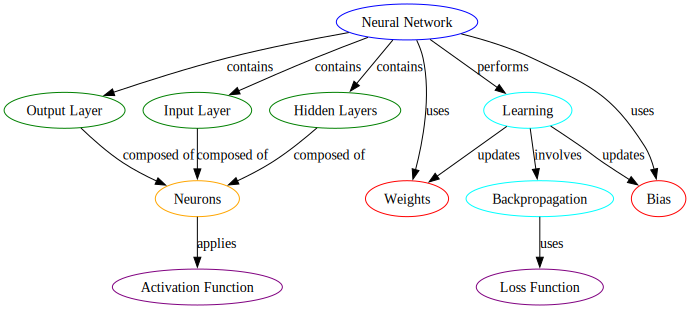

In [23]:
generate_graph("Explain the concept of a neural network.").visualize_knowledge_graph()

## Advanced Iterative Graph Generation

When dealing with extensive or segmented text inputs, processing them all at once might be challenging due to limitations in prompt length or the complexity of the content.  In such scenarios, an iterative approach to building the knowledge graph proves beneficial. This method involves processing the text in smaller, manageable chunks, updating the graph with new information from each chunk.

### What are the benefits of this approach?

- Scalability: This approach can handle large datasets by breaking them down into smaller, more manageable pieces.

- Flexibility: It allows for dynamic updates to the graph, accommodating new information as it becomes available.

- Efficiency: Processing smaller chunks of text can be more efficient and less prone to errors or omissions.

### What's different?

The Previous example laid the foundation, while this new example will adds more complexity and functionality. The Node and Edge classes have been augmented with a __hash__ method, enabling these objects to be used in sets, thereby making it easier to handle duplicates.

In [24]:
class Node(BaseModel):
    id: int
    label: str
    color: str

    def __hash__(self) -> int:
        return hash((id, self.label))
    
class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

    def __hash__(self) -> int:
        return hash((self.source, self.target, self.label))

KnowledgeGraph Class now have ``update`` and ``draw`` methods.

The nodes and edges fields in the KnowledgeGraph class are now optional, providing more flexibility.

``update``: This method allows for the combination and deduplication of two graphs.

``draw``: includes a prefix parameter, facilitating the creation of different graph versions during iterations.

In [25]:
from typing import Optional

class KnowledgeGraph(BaseModel):
    # Optional list of nodes and edges in the knowledge graph
    nodes: Optional[List[Node]] = Field(..., default_factory=list)
    edges: Optional[List[Edge]] = Field(..., default_factory=list)

    def update(self, other: "KnowledgeGraph") -> "KnowledgeGraph":
        # This method updates the current graph with the other graph, deduplicating nodes and edges.
        return KnowledgeGraph(
            nodes=list(set(self.nodes + other.nodes)),  # Combine and deduplicate nodes
            edges=list(set(self.edges + other.edges)),  # Combine and deduplicate edges
        )
    

    def visualize_knowledge_graph(self):
        dot = Digraph(comment="Knowledge Graph")

        for node in self.nodes:
            dot.node(str(node.id), node.label, color=node.color)
        for edge in self.edges:
            dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)
        
        return display(dot)


### Generate itrative graph

The new ``generate_graph`` function is designed to handle a list of inputs iteratively, updating the graph with each new piece of information.

If you look carefully it looks liek a very common pattern in programming, a reduce, or fold function. A simple example could be iterating over a list of find the sum of all the elements squared.

```python
cur_state = 0
for i in [1, 2, 3, 4, 5]:
    c += i**2
print(c)
```

In [27]:
def generate_graph(input: List[str]) -> KnowledgeGraph:
    # Initialize an empty KnowledgeGraph
    cur_state = KnowledgeGraph()

    # Iterate over the input list
    for i, inp in enumerate(input):
        new_updates = client.chat.completions.create(
            model="gpt-3.5-turbo-16k",
            messages=[
                {
                    "role": "system",
                    "content": """You are an iterative knowledge graph builder.
                    You are given the current state of the graph, and you must append the nodes and edges 
                    to it Do not procide any duplcates and try to reuse nodes as much as possible.""",
                },
                {
                    "role": "user",
                    "content": f"""Extract any new nodes and edges from the following:
                    # Part {i}/{len(input)} of the input:

                    {inp}""",
                },
                {
                    "role": "user",
                    "content": f"""Here is the current state of the graph:
                    {cur_state.model_dump_json(indent=2)}""",
                },
            ],
            response_model=KnowledgeGraph,
        )  # type: ignore

        # Update the current state with the new updates
        cur_state = cur_state.update(new_updates)

        # Draw the current state of the graph
        cur_state.visualize_knowledge_graph() 
        
    # Return the final state of the KnowledgeGraph
    return cur_state


### Examples Use Case

In this approach, we process the text in manageable chunks, one at a time.

This method is particularly beneficial when dealing with extensive text that may not fit into a single prompt.

It is especially useful in scenarios such as constructing a knowledge graph for a complex topic, where the information is distributed across multiple documents or sections.

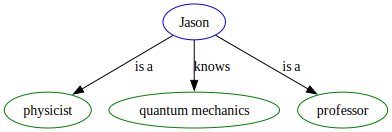

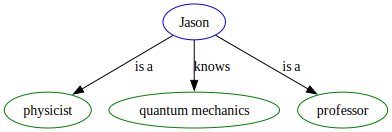

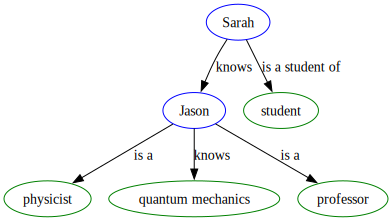

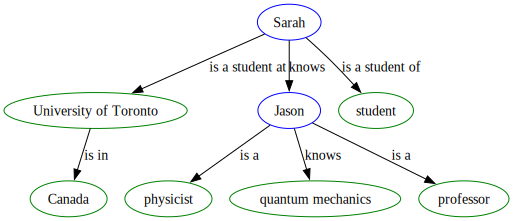

In [28]:
text_chunks = [
    "Jason knows a lot about quantum mechanics. He is a physicist. He is a professor",
    "Professors are smart.",
    "Sarah knows Jason and is a student of his.",
    "Sarah is a student at the University of Toronto. and UofT is in Canada.",
]

graph: KnowledgeGraph = generate_graph(text_chunks)

## Conclusion

This tutorial shows how to generate and visualize a knowledge graph for complex topics. It also demonstrates how to extract graphic knowledge from the language model or provided text. The tutorial highlights the iterative process of building the knowledge graph by processing text in smaller chunks and updating the graph with new information.

Using this approach, we can extract various things, including:

1) People and their relationships in a story.

```python
class People(BaseModel):
    id: str
    name: str
    description: str

class Relationship(BaseModel):
    id: str
    source: str
    target: str
    label: str
    description: str

class Story(BaseModel):
    people: List[People]
    relationships: List[Relationship]
```

2) Task dependencies and action items from a transcript.

```python
class Task(BaseModel):
    id: str
    name: str
    description: str

class Participant(BaseModel):
    id: str
    name: str
    description: str

class Assignment(BaseModel):
    id: str
    source: str
    target: str
    label: str
    description: str

class Transcript(BaseModel):
    tasks: List[Task]
    participants: List[Participant]
    assignments: List[Assignment]
```

3) Key concepts and their relationships from a research paper.
4) Entities and their relationships from a news article.

As an excercise, try to implement one of the above examples.

All of them will follow an idea of iteratively extracting more and more information and accumulating it some state.